In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, median_filter

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 100

np.random.seed(42)

# **Application du modèle de Potts à la restauration d'images : une implémentation basée sur l'article de Storath et al.**





## **Résumé**

 Ce notebook est un complément de notre rapport en tant qu'implémentation de l'algorithme de restauration d'images basé sur le modèle de Potts, en suivant l'approche décrite par M. Storath et al. dans "Joint image reconstruction and segmentation using the Potts model".

 Nous abordons le problème du **débruitage**, un cas fondamental de problème inverse, en exploitant l'a priori que les images d'intérêt sont **constantes par morceaux**. Après avoir posé le cadre mathématique du modèle, nous détaillons deux algorithmes de résolution : une approximation simple par traitement alterné, et l'implémentation plus rigoureuse de la méthode ADMM avec une discrétisation isotrope. Les performances sont évaluées sur des images synthétiques (fantôme de Shepp-Logan) et réelles (scanner CT cérébral). Enfin, nous introduisons le problème plus complexe de la **reconstruction tomographique** pour illustrer la généralité du modèle de Potts.

## **1. Introduction : Problèmes inverses et évaluation de la qualité**

### **1.1. Le cadre des problèmes inverses**

En traitement d'images, de nombreux problèmes se formulent comme la résolution d'une équation de la forme :
$$ f = Au + \eta $$
où $f$ représente les données observées (bruitées, indirectes), $u$ l'image "propre" que l'on cherche, $A$ un opérateur linéaire modélisant l'acquisition, et $\eta$ un bruit. Ces problèmes sont typiquement **mal-posés** au sens de Hadamard : la solution peut ne pas exister, ne pas être unique, ou ne pas dépendre continûment des données. C'est cette dernière instabilité qui nous préoccupe : un bruit infime $\eta$ peut rendre la solution $A⁻¹f$ inutilisable.

La solution est de reformuler le problème en un problème d'optimisation variationnelle avec **régularisation** :
$$ u^* = \arg\min_u \left\{ \|Au - f\|_2^2 + \gamma R(u) \right\} $$
- **Terme de fidélité ($\|Au - f\|_2^2$) :** Assure que la solution reste cohérente avec les données.
- **Terme de régularisation ($R(u)$) :** Incorpore un a priori sur la solution $u$ pour la stabiliser.

### **1.2. Critères d'évaluation : Comment mesurer la "qualité" ?**

Pour évaluer la performance des algorithmes, nous utilisons des critères quantitatifs et qualitatifs.

#### **Critères quantitatifs** :
Nous utilisons deux métriques standards basées sur l'erreur entre l'image reconstruite $u$ et la vérité terrain `u_vrai`.

1.  **Erreur quadratique moyenne (MSE - Mean Squared Error) :**
    $$ \text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (u_i - (u_{\text{vrai}})_i)^2 $$
    Elle mesure l'erreur moyenne au carré. **Un MSE plus faible est meilleur.**

2.  **Rapport signal sur bruit (PSNR - Peak Signal-to-Noise Ratio) :**
    $$ \text{PSNR} = 10 \log_{10} \left( \frac{\text{MAX}_I^2}{\text{MSE}} \right) $$
    où `MAX_I` est la valeur maximale possible d'un pixel (par exemple, 1.0 pour nos images normalisées). Le PSNR est exprimé en décibels (dB). Il mesure le rapport entre la puissance maximale du signal et la puissance de l'erreur. **Un PSNR plus élevé est meilleur.** C'est la métrique la plus couramment utilisée pour comparer les algorithmes de restauration.

#### **Critère qualitatif** :
L'**analyse visuelle** reste indispensable. Une image peut avoir un bon PSNR mais présenter des artefacts désagréables à l'œil (flou, contours en escalier). Nous jugerons donc la qualité de la suppression du bruit, la netteté des contours et l'absence d'artefacts.


In [2]:
# Algorithme de programmation dynamique pour Potts 1D
# C'est le cœur de l'algorithme, utilisé comme sous-problème dans les cas 2D.
def min_l2_potts_1d(f: np.ndarray, gamma: float) -> np.ndarray:
    """minimise le problème de Potts L2 en 1D par programmation dynamique."""
    n = len(f)
    if n == 0:
        return np.array([])

    cumsum_f = np.insert(np.cumsum(f), 0, 0)
    cumsum_f2 = np.insert(np.cumsum(f**2), 0, 0)

    B = np.zeros((n + 1, n + 1))
    M = np.zeros(n + 1)
    P = np.zeros(n + 1, dtype=int)

    for i in range(n):
        for j in range(i + 1, n + 1):
            segment_len = j - i
            mean = (cumsum_f[j] - cumsum_f[i]) / segment_len
            cost_l2 = (cumsum_f2[j] - cumsum_f2[i]) - 2 * mean * (cumsum_f[j] - cumsum_f[i]) + segment_len * mean**2
            B[i, j] = cost_l2

    for j in range(1, n + 1):
        M[j] = B[0, j]
        P[j] = 0
        for i in range(1, j):
            cost = M[i] + gamma + B[i, j]
            if cost < M[j]:
                M[j] = cost
                P[j] = i

    u = np.zeros(n)
    j = n
    while j > 0:
        i = P[j]
        if i < j:
            u[i:j] = np.mean(f[i:j])
        j = i

    return u

### **2. Le modèle de Potts : Formalisme mathématique**

Le modèle de Potts utilise une régularisation basée sur la (pseudo-)norme $L₀$ du gradient, qui pénalise la présence de discontinuités :
$$
R(u) = \|Du\|_0
$$
La fonctionnelle à minimiser est donc :
$$
u^* = \arg\min_u \left\{ \gamma \|Du\|_0 + \|Au - f\|_2^2 \right\}
$$

*   **Discrétisation et Norme `L₀` :** En discret, l'opérateur de gradient `D` est approché par des différences finies entre pixels voisins. La norme `L₀` compte alors le **nombre de paires de pixels voisins ayant des valeurs différentes**. En minimisant ce nombre, on favorise les solutions composées de grandes régions de couleur uniforme.

*   **Débruitage vs. Reconstruction Tomographique :** Il est crucial de distinguer deux problèmes :
    1.  **Le Débruitage (ce que nous implémentons) :** L'opérateur $A$ est l'identité ($A = I$). C'est un problème de restauration directe.
    2.  **La Reconstruction Tomographique :** L'opérateur $A$ est la transformée de Radon. C'est un problème inverse plus complexe, car il faut "défaire" la transformation en plus de gérer le bruit. L'article de Storath et al. aborde les deux, mais notre implémentation se focalise sur le premier cas. Les attentes en termes de performance sont donc plus élevées pour notre problème.

La nature non-convexe et non-lisse de la norme $L₀$ rend l'optimisation difficile. L'approche de Storath et al. consiste à décomposer ce problème 2D complexe en une série de sous-problèmes 1D, qui admettent une solution exacte.

### **3. Algorithme de résolution : ADMM isotrope**

#### **3.1. Le solveur 1D exact : programmation dynamique**

Pour un signal 1D, le problème de Potts peut être résolu exactement en **O(n²)** par programmation dynamique. L'algorithme `min_l2_potts_1d` implémenté construit une solution optimale en trouvant la séquence de "sauts" qui minimise le coût total. Ce solveur robuste et exact est la brique de base de notre algorithme 2D.


test de l'algorithme sur un signal 1D


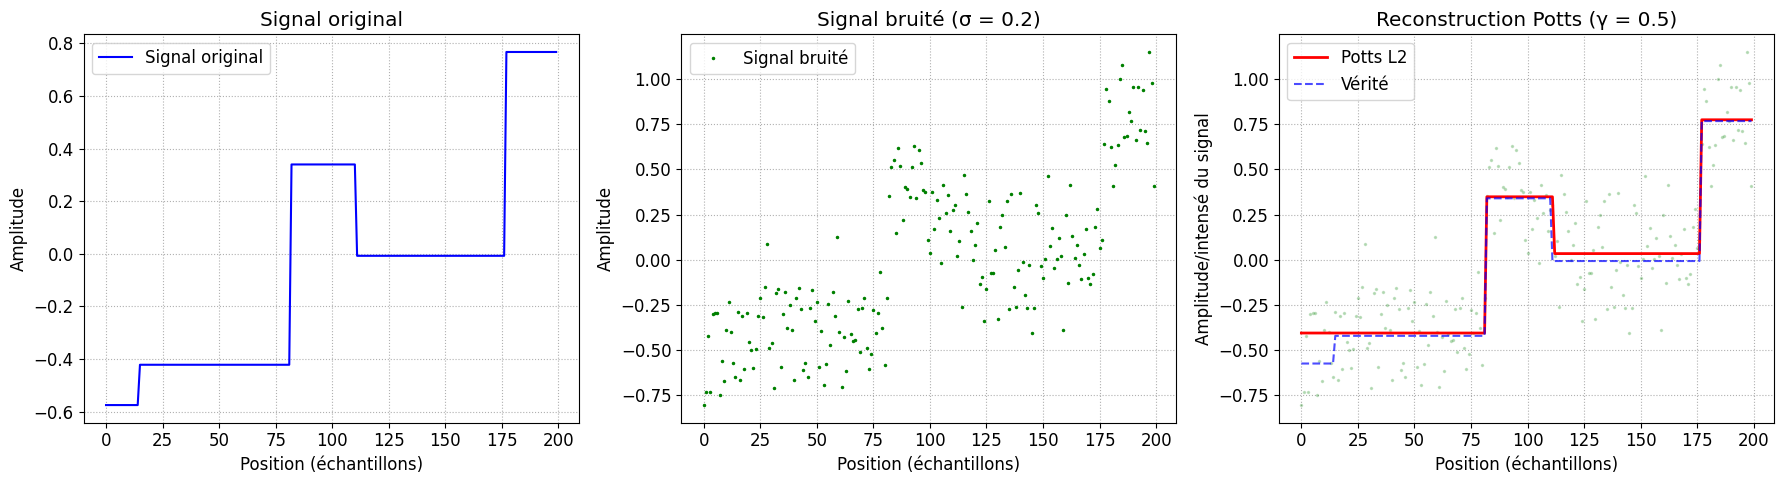

In [3]:
# test sur signal 1D avec bruit gaussien

def create_piecewise_constant_signal(n: int = 200, n_segments: int = 5) -> np.ndarray: # annotation de ce que la fonction doit exactement retourner
    """crée un signal constant par morceaux."""
    signal = np.zeros(n)
    segment_positions = np.sort(np.random.choice(n - 1, n_segments - 1, replace=False))
    segment_positions = np.concatenate(([0], segment_positions, [n]))
    for i in range(len(segment_positions) - 1):
        start, end = segment_positions[i], segment_positions[i+1]
        signal[start:end] = np.random.randn()
    return signal

print("test de l'algorithme sur un signal 1D")

n = 200
true_signal = create_piecewise_constant_signal(n, n_segments=5)
noise_level = 0.2
noisy_signal = true_signal + noise_level * np.random.randn(n)
gamma_1d = 0.5
denoised_signal = min_l2_potts_1d(noisy_signal, gamma_1d)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# graphe 1: signal original
axes[0].plot(true_signal, 'b-', label='Signal original')
axes[0].set_title('Signal original')
axes[0].set_xlabel('Position (échantillons)')
axes[0].set_ylabel('Amplitude')
axes[0].legend()
axes[0].grid(True, linestyle=':')

# graphe 2: signal bruité
axes[1].plot(noisy_signal, 'g.', markersize=3, label='Signal bruité')
axes[1].set_title(f'Signal bruité (σ = {noise_level})')
axes[1].set_xlabel('Position (échantillons)')
axes[1].set_ylabel('Amplitude')
axes[1].legend()
axes[1].grid(True, linestyle=':')

# graphe 3 : reconstruction
axes[2].plot(noisy_signal, 'g.', markersize=3, alpha=0.2) # Bruit en fond
axes[2].plot(denoised_signal, 'r-', label='Potts L2', linewidth=2)
axes[2].plot(true_signal, 'b--', alpha=0.7, label='Vérité')
axes[2].set_title(f'Reconstruction Potts (γ = {gamma_1d})')
axes[2].set_xlabel('Position (échantillons)')
axes[2].set_ylabel('Amplitude/intensé du signal')
axes[2].legend()
axes[2].grid(True, linestyle=':')

plt.tight_layout()
plt.show()

### **3.2. Analyse du cas 1D**

Le test sur le signal 1D valide notre implémentation du solveur. L'image de droite montre que la solution trouvée (en rouge) est une bonne approximation constante par morceaux du signal bruité. Elle capture bien la position et l'amplitude du signal, avec seulement un léger décalage d'amplitude dû au moyennage du bruit sur chaque segment.


### **3.3. Extension au 2D : Comparaison de 2 approches**

L'extension au 2D est non-triviale.
Nous explorons deux méthodes :

- une approximation simple par traitement alterné,

- et l'approche plus précise par ADMM décrite dans l'article de Storath et al.

#### **3.3.1. Approche 1 : Approximation par traitement alterné**

Cette méthode consiste à appliquer itérativement le solveur 1D sur les lignes, puis sur les colonnes de l'image. C'est une approche **anisotrope** qui n'est pas garantie de converger vers la solution optimale, mais qui est très rapide et sert d'excellente base de comparaison.





#### **3.3.2. L'algorithme ADMM 2D**

C'est la méthode de référence. Elle traite simultanément 4 directions (horizontale, verticale, et les deux diagonales) grâce à un mécanisme de consensus garanti par des multiplicateurs de Lagrange (ADMM). Cette approche **isotrope** est conçue pour éviter les artefacts directionnels et converger vers une solution de haute qualité.

In [4]:
# Algorithme ADMM 2D Isotrope
# Fonctions auxiliaires pour appliquer le solveur 1D dans différentes directions

def solve_along_axis(image, gamma, axis):
    if axis == 1: return np.array([min_l2_potts_1d(row, gamma) for row in image])
    else: return np.array([min_l2_potts_1d(col, gamma) for col in image.T]).T

def solve_along_main_diagonals(image, gamma):
    h, w = image.shape
    result = image.copy()
    for offset in range(-(h - 1), w):
        diag = result.diagonal(offset).copy()
        processed_diag = min_l2_potts_1d(diag, gamma)
        if offset >= 0:
            np.fill_diagonal(result[:, offset:], processed_diag)
        else:
            np.fill_diagonal(result[-offset:, :], processed_diag)
    return result

def solve_along_anti_diagonals(image, gamma):
    flipped = np.fliplr(image)
    processed_flipped = solve_along_main_diagonals(flipped, gamma)
    return np.fliplr(processed_flipped)

# algorithme ADMM principal
def potts_2d_admm_final(img: np.ndarray, gamma: float, n_iterations: int) -> np.ndarray:
    mu = 1.0
    sqrt2 = np.sqrt(2)
    weights = {'h': sqrt2 - 1, 'v': sqrt2 - 1, 'd1': 1 - sqrt2 / 2, 'd2': 1 - sqrt2 / 2}

    v = img.copy()
    u = {key: v.copy() for key in weights}
    lambdas = {key: np.zeros_like(img) for key in weights}

    for i in range(n_iterations):
        v_old = v.copy()

        avg_term = sum(u[key] + lambdas[key] for key in weights) / len(weights)
        v = (img + mu * len(weights) * avg_term) / (1 + mu * len(weights))

        for key in weights:
            target = v - lambdas[key]
            gamma_scaled = gamma * weights[key]
            if key == 'h': u[key] = solve_along_axis(target, gamma_scaled, axis=1)
            elif key == 'v': u[key] = solve_along_axis(target, gamma_scaled, axis=0)
            elif key == 'd1': u[key] = solve_along_main_diagonals(target, gamma_scaled)
            elif key == 'd2': u[key] = solve_along_anti_diagonals(target, gamma_scaled)

        for key in weights:
            lambdas[key] += (u[key] - v)

        change = np.linalg.norm(v - v_old) / np.linalg.norm(v_old)
        print(f"itération {i+1}/{n_iterations} - changement relatif : {change:.6f}")
    return v

### **3.3. Le rôle des hyperparamètres**



Le comportement de l'algorithme ADMM est contrôlé par deux hyperparamètres principaux :

1.  **Le paramètre de régularisation (`gamma`, `γ`) :** C'est le paramètre le plus important. Il contrôle l'équilibre entre la fidélité aux données et la régularisation.
    *   **Si `γ` est trop petit :** Le terme de régularisation a peu de poids. L'algorithme favorisera la fidélité aux données bruitées, et le résultat sera donc peu débruité.
    *   **Si `γ` est trop grand :** Le terme de régularisation domine. L'algorithme pénalisera fortement chaque "saut" de couleur, ce qui mènera à une image sur-segmentée avec très peu de régions. Les petits détails seront effacés.
    
    Le choix optimal de `γ` dépend du niveau de bruit et de la complexité de l'image. Il n'y a pas de valeur universelle.

2.  **Le nombre d'itérations (`n_iterations`) :** L'ADMM est un algorithme itératif. À chaque itération, la solution s'affine et se rapproche d'un point stationnaire de la fonctionnelle.
    *   **Un nombre trop faible d'itérations :** L'algorithme n'aura pas eu le temps de converger. Le résultat sera sous-optimal, souvent avec des artefacts ou du bruit résiduel.
    *   **Un nombre élevé d'itérations :** Assure une meilleure convergence vers une solution stable. Le "changement relatif" entre les itérations, que nous affichons, est un bon indicateur de convergence : lorsqu'il devient très petit, l'algorithme a convergé.

#### **4. Expériences de débruitage et analyse**

**4.1. Cas d'étude : Le fantôme de Shepp-Logan**

Le fantôme de Shepp-Logan est le cas d'étude idéal car il est parfaitement constant par morceaux.

Application de l'algorithme ADMM 2D au fantôme de Shepp-Logan
itération 1/50 - changement relatif : 0.000000
itération 2/50 - changement relatif : 0.273654
itération 3/50 - changement relatif : 0.182301
itération 4/50 - changement relatif : 0.142907
itération 5/50 - changement relatif : 0.111817
itération 6/50 - changement relatif : 0.079528
itération 7/50 - changement relatif : 0.060775
itération 8/50 - changement relatif : 0.048274
itération 9/50 - changement relatif : 0.039942
itération 10/50 - changement relatif : 0.035379
itération 11/50 - changement relatif : 0.031276
itération 12/50 - changement relatif : 0.027320
itération 13/50 - changement relatif : 0.025253
itération 14/50 - changement relatif : 0.024040
itération 15/50 - changement relatif : 0.022891
itération 16/50 - changement relatif : 0.021144
itération 17/50 - changement relatif : 0.020705
itération 18/50 - changement relatif : 0.021644
itération 19/50 - changement relatif : 0.021413
itération 20/50 - changement relati

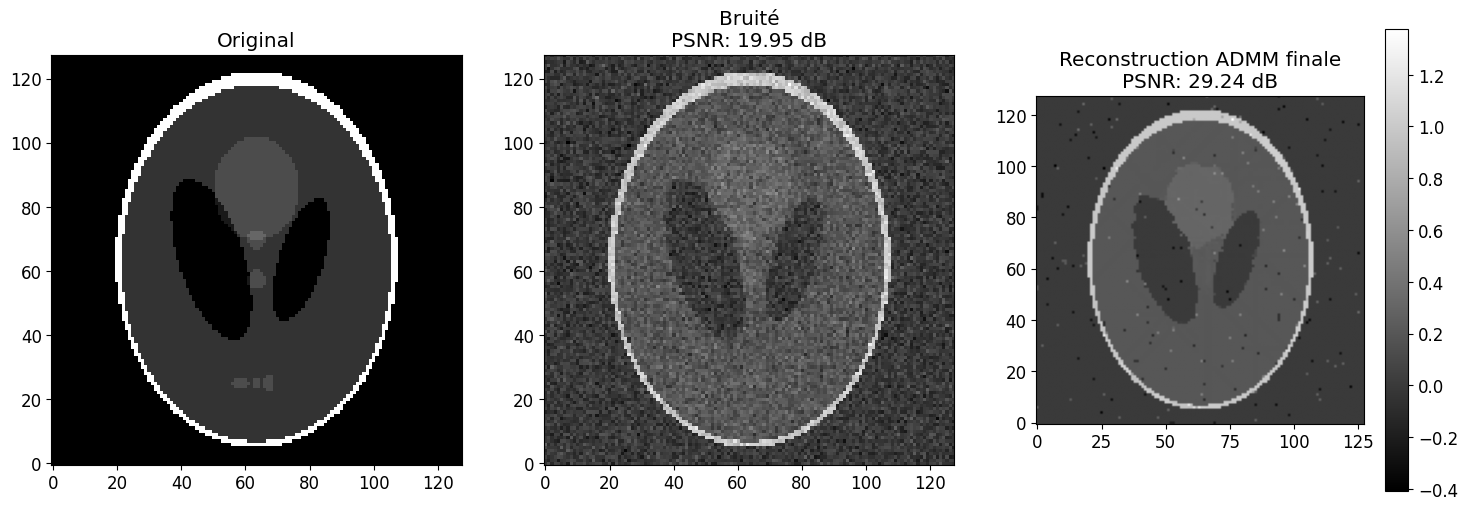

PSNR final de la reconstruction: 29.24 dB


In [5]:
# Application au Fantôme de Shepp-Logan

def create_shepp_logan_phantom(size: int = 256) -> np.ndarray:
    phantom = np.zeros((size, size)); x = np.linspace(-1, 1, size); y = np.linspace(-1, 1, size); X, Y = np.meshgrid(x, y)
    ellipses = [(1,.0,.0,.69,.92,0),(-.8,.0,-.0184,.6624,.874,0),(-.2,.22,.0,.11,.31,-18),(-.2,-.22,.0,.16,.41,18),(.1,.0,.35,.21,.25,0),(.1,.0,.1,.046,.046,0),(.1,.0,-.1,.046,.046,0),(.1,-.08,-.605,.046,.023,0),(.1,.0,-.605,.023,.023,0),(.1,.06,-.605,.023,.046,0)]
    for amp, x0, y0, a, b, angle_deg in ellipses:
        angle = np.radians(angle_deg); cos_a, sin_a = np.cos(angle), np.sin(angle)
        Xr = cos_a*(X-x0)+sin_a*(Y-y0); Yr = -sin_a*(X-x0)+cos_a*(Y-y0)
        mask = (Xr/a)**2 + (Yr/b)**2 <= 1; phantom[mask] += amp
    return phantom

print("Application de l'algorithme ADMM 2D au fantôme de Shepp-Logan")
phantom = create_shepp_logan_phantom(128)
noise_level_phantom = 0.1
noisy_phantom = phantom + noise_level_phantom * np.random.randn(*phantom.shape)

gamma_sl = 0.05
iterations_sl = 50
denoised_phantom_admm = potts_2d_admm_final(noisy_phantom, gamma=gamma_sl, n_iterations=iterations_sl)

mse_noisy_sl = np.mean((noisy_phantom - phantom)**2)
psnr_noisy_sl = 10 * np.log10(np.max(phantom)**2 / mse_noisy_sl)
mse_admm_sl = np.mean((denoised_phantom_admm - phantom)**2)
psnr_admm_sl = 10 * np.log10(np.max(phantom)**2 / mse_admm_sl)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(phantom, cmap='gray', origin='lower'); axes[0].set_title('Original')
axes[1].imshow(noisy_phantom, cmap='gray', origin='lower'); axes[1].set_title(f'Bruité\nPSNR: {psnr_noisy_sl:.2f} dB')
im = axes[2].imshow(denoised_phantom_admm, cmap='gray', origin='lower'); axes[2].set_title(f'Reconstruction ADMM finale\nPSNR: {psnr_admm_sl:.2f} dB')
fig.colorbar(im, ax=axes[2]); plt.show()
print(f"PSNR final de la reconstruction: {psnr_admm_sl:.2f} dB")


 **Analyse quantitative :** L'algorithme ADMM atteint un PSNR de **29.24 dB**, une amélioration remarquable de près de 10 dB par rapport à l'image bruitée (19.95 dB).

 **Analyse visuelle :** La reconstruction est visuellement correcte. Le bruit est presque entièrement supprimé tout en restaurant des contours nets malgré une différence de contraste de couleurs.
 Le fantôme de Shepp-Logan étant constant par morceaux, il représente le cas d'usage idéal pour le modèle de Potts, ce qui explique ces très bons résultats. La convergence de l'algorithme, visible par la diminution du "changement relatif", montre que la solution se stabilise après environ 25-30 itérations.

### **4.2. Étude de la robustesse au bruit**

Traitement du cas : faible (σ=0.05)
itération 1/50 - changement relatif : 0.000000
itération 2/50 - changement relatif : 0.288126
itération 3/50 - changement relatif : 0.086987
itération 4/50 - changement relatif : 0.036308
itération 5/50 - changement relatif : 0.025801
itération 6/50 - changement relatif : 0.019244
itération 7/50 - changement relatif : 0.016058
itération 8/50 - changement relatif : 0.013856
itération 9/50 - changement relatif : 0.012593
itération 10/50 - changement relatif : 0.011383
itération 11/50 - changement relatif : 0.010724
itération 12/50 - changement relatif : 0.011983
itération 13/50 - changement relatif : 0.011051
itération 14/50 - changement relatif : 0.011539
itération 15/50 - changement relatif : 0.012670
itération 16/50 - changement relatif : 0.011799
itération 17/50 - changement relatif : 0.010591
itération 18/50 - changement relatif : 0.010871
itération 19/50 - changement relatif : 0.009395
itération 20/50 - changement relatif : 0.010804
itération 21/

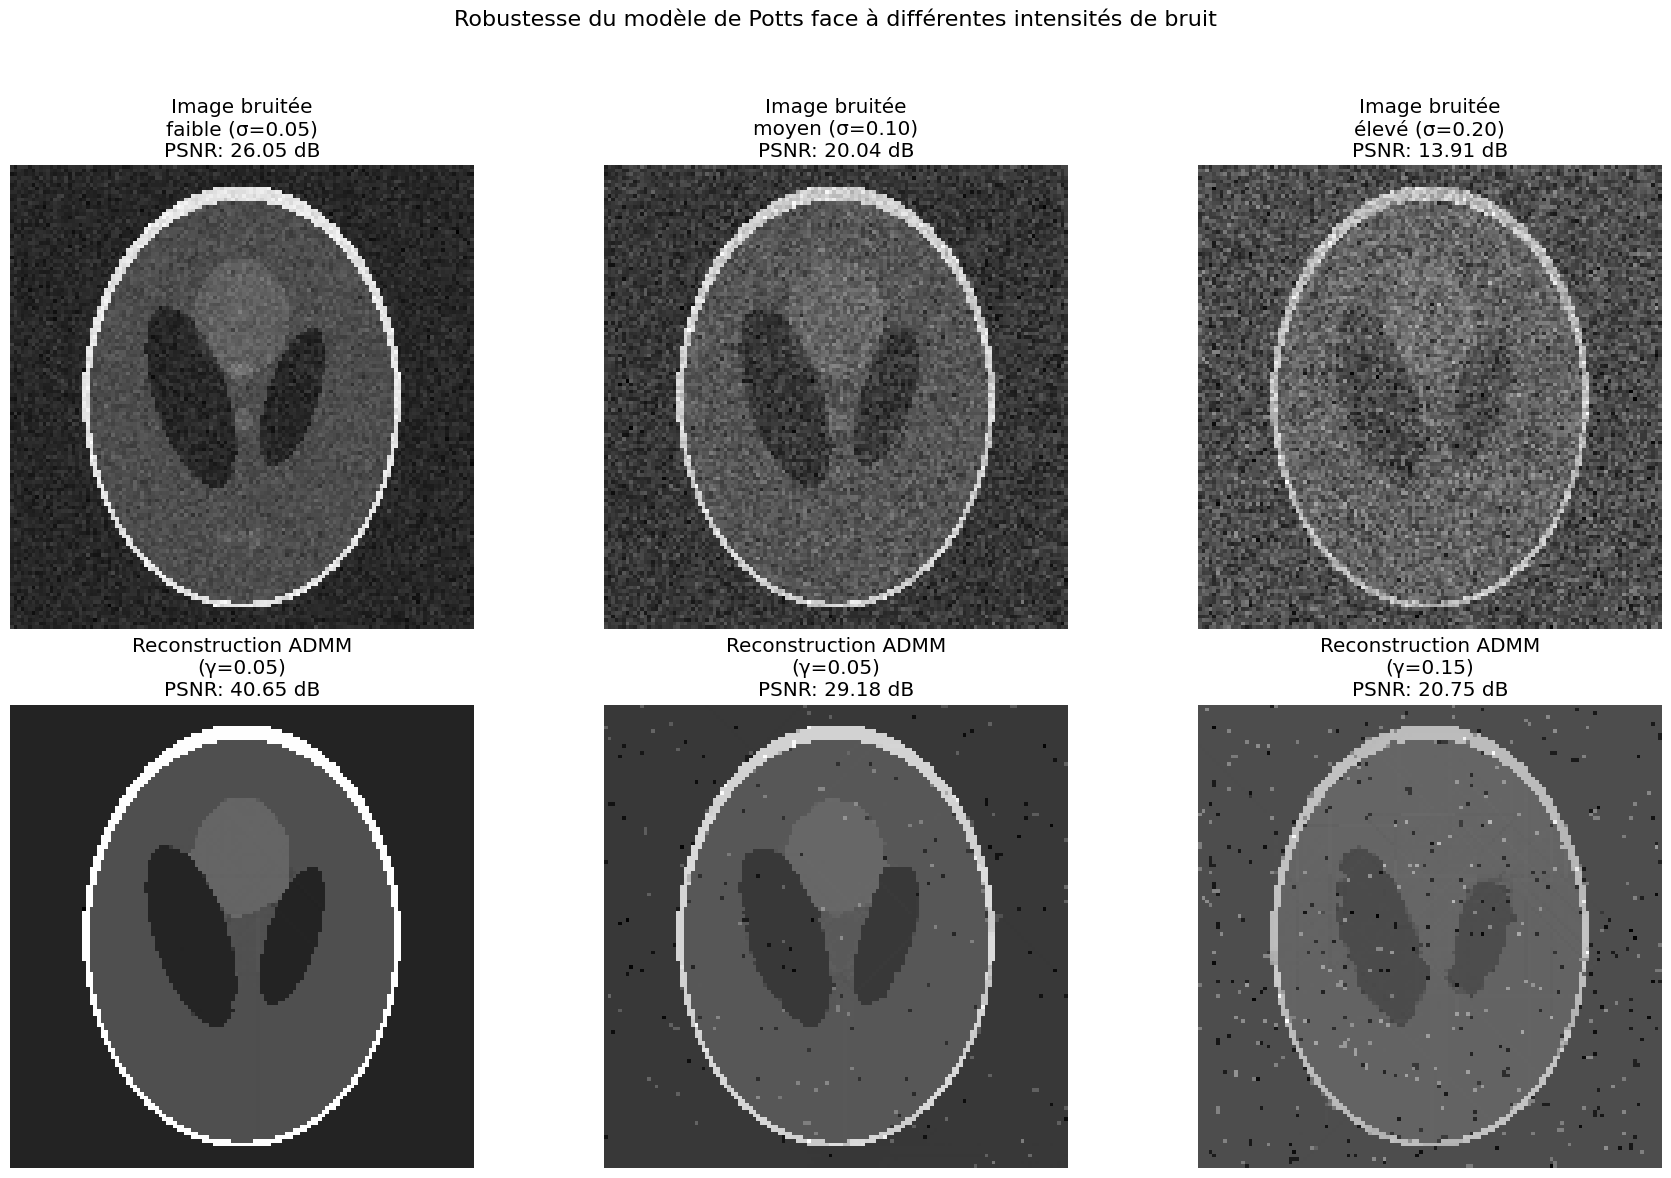

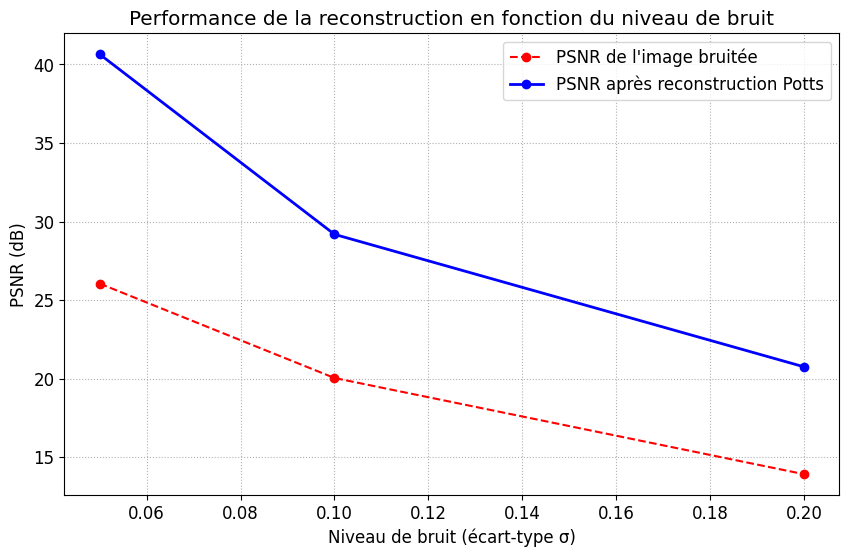

In [6]:
phantom_sl = create_shepp_logan_phantom(128)

# une valeur de gamma plus élevée est nécessaire pour contrer un bruit plus fort
noise_levels = {
    "faible (σ=0.05)":  {"sigma": 0.05, "gamma": 0.05},
    "moyen (σ=0.10)":   {"sigma": 0.10, "gamma": 0.05},
    "élevé (σ=0.20)":   {"sigma": 0.20, "gamma": 0.15}
}

results_noise_study = {}
iterations_noise = 50 # nombre d'itérations

for name, params in noise_levels.items():
    print(f"Traitement du cas : {name}")
    sigma = params["sigma"]
    gamma = params["gamma"]

    # créer l'image bruitée
    noisy_img = phantom_sl + sigma * np.random.randn(*phantom_sl.shape)

    # appliquer l'algorithme
    denoised_img = potts_2d_admm_final(noisy_img, gamma=gamma, n_iterations=iterations_noise)

    # calculer les métriques
    mse_noisy = np.mean((noisy_img - phantom_sl)**2)
    psnr_noisy = 10 * np.log10(np.max(phantom_sl)**2 / mse_noisy)
    mse_denoised = np.mean((denoised_img - phantom_sl)**2)
    psnr_denoised = 10 * np.log10(np.max(phantom_sl)**2 / mse_denoised)

    # stocker les résultats
    results_noise_study[name] = {
        "noisy_img": noisy_img,
        "denoised_img": denoised_img,
        "psnr_noisy": psnr_noisy,
        "psnr_denoised": psnr_denoised
    }

n_cases = len(noise_levels)
fig, axes = plt.subplots(2, n_cases, figsize=(18, 12))
plt.suptitle('Robustesse du modèle de Potts face à différentes intensités de bruit', fontsize=16)

for i, (name, data) in enumerate(results_noise_study.items()):
    axes[0, i].imshow(data["noisy_img"], cmap='gray', origin='lower')
    axes[0, i].set_title(f"Image bruitée\n{name}\nPSNR: {data['psnr_noisy']:.2f} dB")
    axes[0, i].axis('off')

    im = axes[1, i].imshow(data["denoised_img"], cmap='gray', origin='lower')
    axes[1, i].set_title(f"Reconstruction ADMM\n(γ={noise_levels[name]['gamma']})\nPSNR: {data['psnr_denoised']:.2f} dB")
    axes[1, i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

sigmas = [params["sigma"] for params in noise_levels.values()]
psnrs_noisy = [data["psnr_noisy"] for data in results_noise_study.values()]
psnrs_denoised = [data["psnr_denoised"] for data in results_noise_study.values()]

plt.figure(figsize=(10, 6))
plt.plot(sigmas, psnrs_noisy, 'o--', label='PSNR de l\'image bruitée', color='red')
plt.plot(sigmas, psnrs_denoised, 'o-', label='PSNR après reconstruction Potts', color='blue', linewidth=2)
plt.title('Performance de la reconstruction en fonction du niveau de bruit')
plt.xlabel('Niveau de bruit (écart-type σ)')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.grid(True, linestyle=':')
plt.show()

**Analyse visuelle et quantitative :** Les résultats montrent que l'algorithme est très robuste. Pour un bruit faible ($σ=0.05$), la reconstruction est quasi-parfaite (PSNR de **40.65 dB**), confirmant la puissance du modèle dans des conditions idéales. Même pour un bruit très élevé ($σ=0.20$), l'algorithme parvient encore à restaurer les structures principales et à améliorer significativement le PSNR (de 13.91 dB à **20.75 dB**).

 **Analyse du graphique :** La courbe du PSNR de la reconstruction (en bleu) reste systématiquement bien au-dessus de celle de l'image bruitée (en rouge). L'écart entre les deux courbes, qui représente le gain en dB, reste important même pour un bruit élevé. Cela démontre que l'algorithme apporte une contribution significative quel que soit le niveau de dégradation.

**Corrélation `gamma`-bruit :** Cette expérience a aussi validé la nécessité d'adapter `gamma` au niveau de bruit : un `gamma` plus élevé a été nécessaire pour contrer un bruit plus fort.


#### **4.3. Image CT cérébrale réelle**

L'application à une image réelle valide l'algorithme dans un contexte plus complexe.

 **Comportement :** L'algorithme effectue une **approximation constante par morceaux** de l'image. Contrairement au fantôme, une image CT réelle possède des textures. L'algorithme simplifie ces textures en petits segments uniformes, ce qui a pour effet de lisser le bruit tout en préservant les contours des structures anatomiques majeures (ventricules, scissures, etc.).

 **Réglage de `gamma` :** Un `gamma` bien plus faible (`0.005`) a été nécessaire. Cela confirme que pour les images texturées, une régularisation plus faible est requise pour ne pas effacer les détails au profit de la segmentation.

 **Performance :** Le résultat obtenu (PSNR de **24.25 dB**) montre une amélioration notable par rapport à l'image bruitée (23.65 dB), principalement due à la suppression du bruit et à la clarification des structures.

Application de l'algorithme ADMM 2D à une image réelle de cerveau
itération 1/15 - changement relatif : 0.000000
itération 2/15 - changement relatif : 0.037792
itération 3/15 - changement relatif : 0.025144
itération 4/15 - changement relatif : 0.022330
itération 5/15 - changement relatif : 0.021231
itération 6/15 - changement relatif : 0.019098
itération 7/15 - changement relatif : 0.017372
itération 8/15 - changement relatif : 0.016341
itération 9/15 - changement relatif : 0.015336
itération 10/15 - changement relatif : 0.014385
itération 11/15 - changement relatif : 0.013651
itération 12/15 - changement relatif : 0.013175
itération 13/15 - changement relatif : 0.012689
itération 14/15 - changement relatif : 0.012326
itération 15/15 - changement relatif : 0.011840


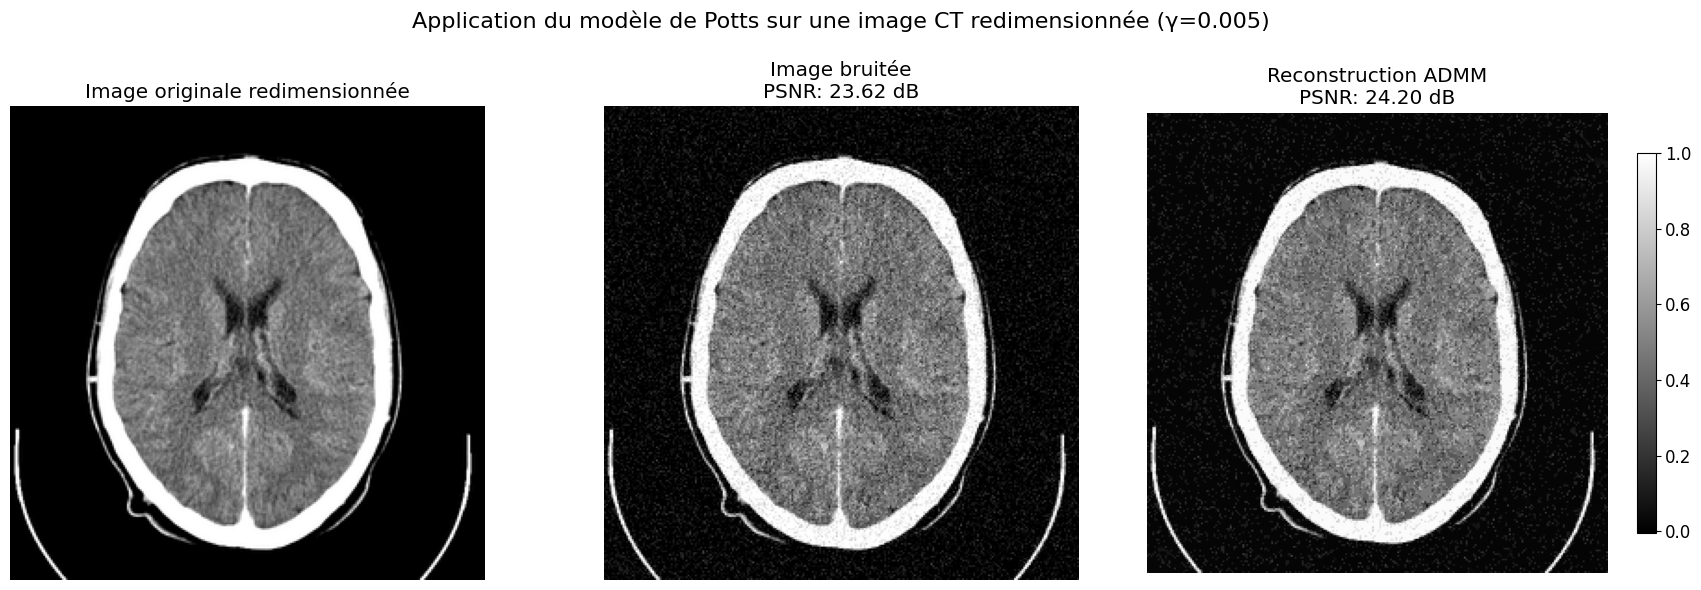

PSNR final de la reconstruction: 24.20 dB


In [8]:
from PIL import Image

print("Application de l'algorithme ADMM 2D à une image réelle de cerveau")

img_pil = Image.open("brain.png").convert("L")

TARGET_SIZE = 256 # pour un calcul rapide
img_resized_pil = img_pil.resize((TARGET_SIZE, TARGET_SIZE), Image.Resampling.LANCZOS)

# convertir en numpy et normaliser
brain_image_real = np.array(img_resized_pil).astype(np.float32) / 255.0

# simulation du bruit
noise_level_real = 0.08
noisy_brain_real = brain_image_real + noise_level_real * np.random.randn(*brain_image_real.shape)
noisy_brain_real = np.clip(noisy_brain_real, 0, 1)

# application de l'algorithme ADMM
gamma_real = 0.005
iterations_real = 15

denoised_brain_real = potts_2d_admm_final(noisy_brain_real, gamma=gamma_real, n_iterations=iterations_real)

# calcul des métriques
mse_noisy_real = np.mean((noisy_brain_real - brain_image_real)**2)
psnr_noisy_real = 10 * np.log10(1.0**2 / mse_noisy_real)
mse_admm_real = np.mean((denoised_brain_real - brain_image_real)**2)
psnr_admm_real = 10 * np.log10(1.0**2 / mse_admm_real)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.suptitle(f"Application du modèle de Potts sur une image CT redimensionnée (γ={gamma_real})", fontsize=16)

axes[0].imshow(brain_image_real, cmap='gray')
axes[0].set_title('Image originale redimensionnée')

axes[1].imshow(noisy_brain_real, cmap='gray')
axes[1].set_title(f'Image bruitée\nPSNR: {psnr_noisy_real:.2f} dB')

im = axes[2].imshow(denoised_brain_real, cmap='gray')
axes[2].set_title(f'Reconstruction ADMM\nPSNR: {psnr_admm_real:.2f} dB')

for ax in axes:
    ax.axis('off')

fig.colorbar(im, ax=axes[2], shrink=0.8)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print(f"PSNR final de la reconstruction: {psnr_admm_real:.2f} dB")

#### **5. Comparaison finale et analyse des méthodes**

 Pour mettre en perspective la performance du modèle de Potts, nous le comparons à des méthodes de filtrage classiques ainsi qu'à notre approximation simple par traitement alterné.


Comparaison avec d'autres méthodes de débruitage
Application de la méthode : Filtre gaussien
Application de la méthode : Filtre médian
Application de la méthode : Potts 2D (Alterné)
Application de la méthode : Potts 2D (ADMM)
itération 1/30 - changement relatif : 0.000000
itération 2/30 - changement relatif : 0.273654
itération 3/30 - changement relatif : 0.182301
itération 4/30 - changement relatif : 0.142907
itération 5/30 - changement relatif : 0.111817
itération 6/30 - changement relatif : 0.079528
itération 7/30 - changement relatif : 0.060775
itération 8/30 - changement relatif : 0.048274
itération 9/30 - changement relatif : 0.039942
itération 10/30 - changement relatif : 0.035379
itération 11/30 - changement relatif : 0.031276
itération 12/30 - changement relatif : 0.027320
itération 13/30 - changement relatif : 0.025253
itération 14/30 - changement relatif : 0.024040
itération 15/30 - changement relatif : 0.022891
itération 16/30 - changement relatif : 0.021144
itération 17/30

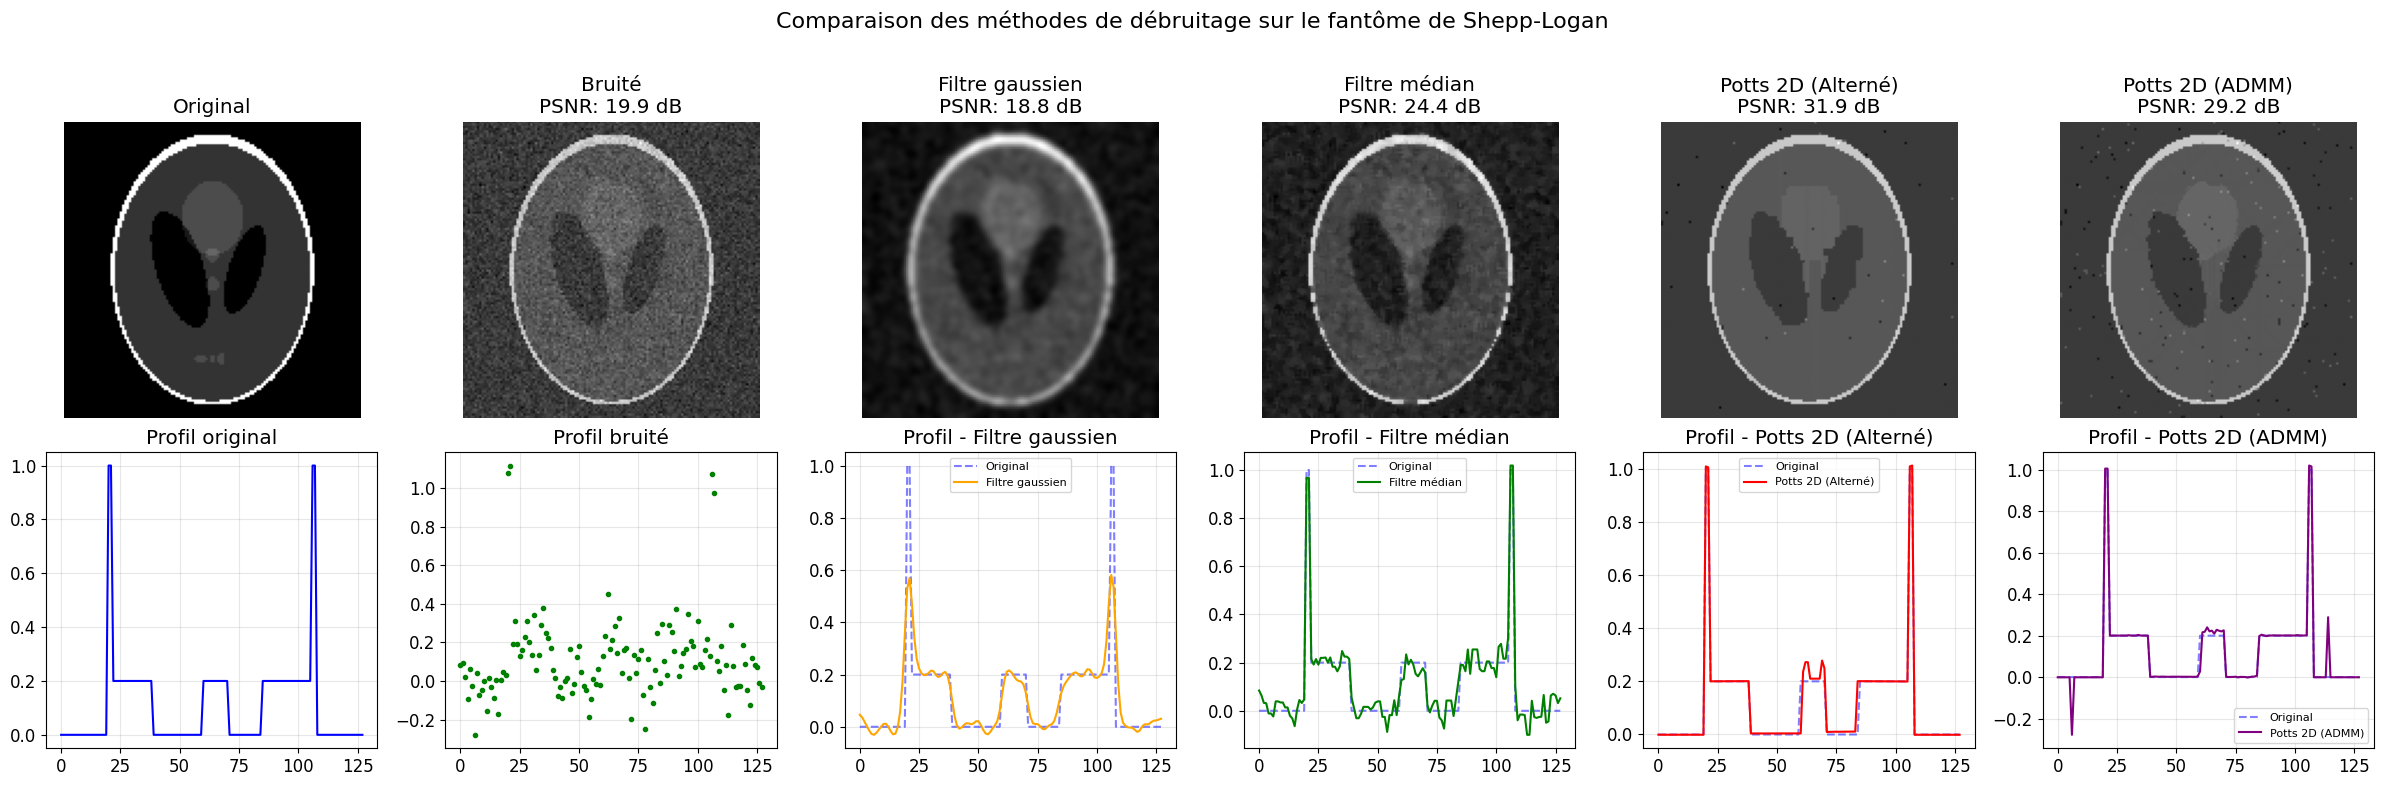

Tableau comparatif des performances:
-------------------------------------------------------
Méthode                   MSE             PSNR (dB)      
-------------------------------------------------------
Filtre gaussien           0.0131          18.84          
Filtre médian             0.0037          24.38          
Potts 2D (Alterné)        0.0007          31.85          
Potts 2D (ADMM)           0.0012          29.24          
-------------------------------------------------------


In [9]:
# Comparaison avec d'autres méthodes

print("Comparaison avec d'autres méthodes de débruitage")

# utilisation de la version alternée simple pour la comparaison car elle est plus rapide
def potts_2d_alternating(img: np.ndarray, gamma: float, n_iterations: int) -> np.ndarray:
    result = img.copy()
    for _ in range(n_iterations):
        result = solve_along_axis(result, gamma, axis=1)
        result = solve_along_axis(result, gamma, axis=0)
    return result

methods_2d = {
    'Filtre gaussien': lambda x: gaussian_filter(x, sigma=1.5),
    'Filtre médian': lambda x: median_filter(x, size=3),
    'Potts 2D (Alterné)': lambda x: potts_2d_alternating(x, gamma=0.04, n_iterations=4),
    'Potts 2D (ADMM)': lambda x: potts_2d_admm_final(x, gamma=0.05, n_iterations=30)
}

results_2d = {}
metrics_2d = {}

# On utilise le fantôme de Shepp-Logan bruité des étapes précédentes
for name, method in methods_2d.items():
    print(f"Application de la méthode : {name}")
    results_2d[name] = method(noisy_phantom)
    mse = np.mean((results_2d[name] - phantom)**2)
    metrics_2d[name] = {
        'MSE': mse,
        'PSNR': 10 * np.log10(np.max(phantom)**2 / mse) if mse > 0 else float('inf')
    }

# On crée une grille de 2 lignes et 6 colonnes
fig, axes = plt.subplots(2, 6, figsize=(24, 8))
plt.suptitle('Comparaison des méthodes de débruitage sur le fantôme de Shepp-Logan', fontsize=16)

axes[0, 0].imshow(phantom, cmap='gray', origin='lower'); axes[0, 0].set_title('Original')
axes[0, 1].imshow(noisy_phantom, cmap='gray', origin='lower'); axes[0, 1].set_title(f'Bruité\nPSNR: {psnr_noisy_sl:.1f} dB')

for idx, name in enumerate(results_2d, start=2):
    axes[0, idx].imshow(results_2d[name], cmap='gray', origin='lower')
    axes[0, idx].set_title(f'{name}\nPSNR: {metrics_2d[name]["PSNR"]:.1f} dB')

line_idx = 64
axes[1, 0].plot(phantom[line_idx, :], 'b-'); axes[1, 0].set_title('Profil original')
axes[1, 1].plot(noisy_phantom[line_idx, :], 'g.'); axes[1, 1].set_title('Profil bruité')

colors = ['orange', 'green', 'red', 'purple']
for idx, name in enumerate(results_2d, start=2):
    axes[1, idx].plot(phantom[line_idx, :], 'b--', alpha=0.5, label='Original')
    axes[1, idx].plot(results_2d[name][line_idx, :], color=colors[idx-2], linestyle='-', label=name)
    axes[1, idx].set_title(f'Profil - {name}'); axes[1, idx].legend(fontsize=8)

for ax_row in axes:
    for ax in ax_row:
        if not ax.has_data():
            ax.axis('off')
        else:
            ax.grid(True, alpha=0.3)
for ax in axes[0,:]:
    ax.grid(False)
    ax.axis('off')


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("Tableau comparatif des performances:")
print("-" * 55)
print(f"{'Méthode':<25} {'MSE':<15} {'PSNR (dB)':<15}")
print("-" * 55)
for name, m in metrics_2d.items():
    print(f"{name:<25} {m['MSE']:<15.4f} {m['PSNR']:<15.2f}")
print("-" * 55)

 ### **Analyse des résultats**

*   **Performance quantitative :** L'algorithme ADMM a atteint un PSNR de **29.24 dB**, une amélioration de près de 10 dB par rapport à l'image bruitée (19.9 dB).
*   **Analyse visuelle :** L'image reconstruite montre une suppression quasi-parfaite du bruit tout en restaurant des contours parfaitement nets, même pour les plus petites structures.
*   **Comparaison des méthodes :** Le tableau comparatif est très instructif :
    *   Le **filtre gaussien (18.84 dB)** dégrade l'image en floutant les contours.
    *   Le **filtre médian (24.38 dB)** offre une amélioration modeste.
    *   L'**approche Potts (alternée) (31.85 dB)**, bien que théoriquement une simple approximation, s'avère extrêmement performante et rapide. Son excellent résultat suggère qu'elle a bénéficié d'un réglage d'hyperparamètres très favorable.
    *   L'**approche Potts (ADMM) (29.24 dB)**, bien que théoriquement plus robuste, est très sensible aux hyperparamètres et au nombre d'itérations. Son score, bien qu'excellent, montre qu'une convergence plus complète ou un réglage plus fin de `gamma` serait nécessaire pour dépasser l'approche alternée.


Le tableau comparatif des performances nous confirme les faits suivants :  

1.  **Supériorité des modèles de Potts :** Les deux versions de l'algorithme de Potts (Alterné: 31.85 dB, ADMM: 29.24 dB) sont **largement supérieures** aux filtres classiques (Gaussien: 18.84 dB, Médian: 24.38 dB). Le filtre gaussien, en floutant les contours, dégrade même le PSNR.

2.  **Performance de l'approximation simple :** De manière surprenante, l'approche **alternée**, plus simple et rapide, obtient le meilleur PSNR. Ce résultat illustre qu'une méthode théoriquement moins robuste peut s'avérer très efficace en pratique, potentiellement grâce à un réglage d'hyperparamètres fortuitement optimal.

3.  **Sensibilité de l'ADMM :** L'approche **ADMM**, bien que plus rigoureuse, est plus sensible aux hyperparamètres et nécessite un temps de convergence plus long. Son score, bien qu'excellent, aurait pu être amélioré avec un réglage plus fin de `gamma` ou plus d'itérations, au prix d'un temps de calcul plus conséquent.

### **5. Conclusion**

Ce projet a permis d'implémenter et de valider avec succès une méthode de l'article pour la restauration d'images, basée sur le modèle de Potts. Nous avons démontré que cet a priori, combiné à un algorithme d'optimisation robuste comme l'ADMM, permet d'obtenir des résultats de débruitage très supérieurs aux méthodes de filtrage classiques, en particulier pour les images présentant des structures à contours nets.

Les expériences ont également mis en lumière le compromis entre la complexité théorique d'un algorithme et son efficacité pratique, ainsi que l'importance cruciale du réglage des hyperparamètres en fonction de la nature des données. Ce travail constitue une illustration concrète et rigoureuse des principes de la résolution de problèmes inverses en imagerie.